In [1]:
from sklearn import cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# Iris dataset using kmeans, agglomerative clustering (agnes), and DBSCAN

In [2]:
iris = pd.read_csv('iris.data', 
                   header=None, 
                   names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
                  )

In [3]:
iris.species = iris.species.astype('category')

In [4]:
iris['cats'] = iris.species.cat.codes

### First, a 5D visualization

In [5]:
def plot_iris_group(iris, group, ax):
    
    m = ['o', '^', 's']

    groups = iris.groupby(group)

    for (_, group), marker in zip(groups, m):
        x,y,z = group.sepal_length, group.sepal_width, group.petal_length
        c = group.petal_width
        ax.scatter(x, y, z, c=c, cmap=plt.hot(), marker=marker)
    return ax

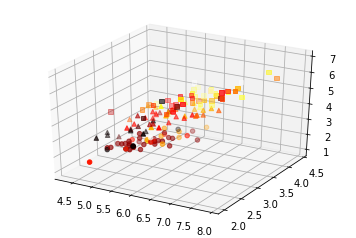

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_iris_group(iris, 'species', ax)

> One class is linearly separable from the other 2; the latter are NOT linearly separable from each other.

The bottom line of circles is setosa, and is distinct. The other grouping isn't very clear

In [7]:
iris_attributes = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [8]:
kmeans_iris = cluster.KMeans(n_clusters=3)

In [9]:
iris['kmeans'] = kmeans_iris.fit_predict(iris[iris_attributes])

In [10]:
agnes = cluster.AgglomerativeClustering(n_clusters=3)

In [11]:
iris['agnes'] = agnes.fit_predict(iris[iris_attributes])

In [12]:
dbscan = cluster.DBSCAN(eps=.5, min_samples=4)

In [13]:
iris['dbscan'] = dbscan.fit_predict(iris[iris_attributes])
iris['dbscan'] = iris['dbscan'].replace(-1, np.NaN)

### What cluster is each species?

In [14]:
iris.groupby('species').mean()

,sepal_length,sepal_width,petal_length,petal_width,cats,kmeans,agnes,dbscan
species,,,,,,,,
Iris-setosa,5.006,3.418,1.464,0.244,0,1.00,1.00,0.000000
Iris-versicolor,5.936,2.770,4.260,1.326,1,1.92,0.04,1.083333
Iris-virginica,6.588,2.974,5.552,2.026,2,0.56,1.40,1.000000


### Where do the algorithms differ?

In [15]:
iris.query('kmeans != agnes | kmeans != dbscan | agnes != dbscan').head()

,sepal_length,sepal_width,petal_length,petal_width,species,cats,kmeans,agnes,dbscan
0,5.1,3.5,1.4,0.2,Iris-setosa,0,1,1,0.0
1,4.9,3.0,1.4,0.2,Iris-setosa,0,1,1,0.0
2,4.7,3.2,1.3,0.2,Iris-setosa,0,1,1,0.0
3,4.6,3.1,1.5,0.2,Iris-setosa,0,1,1,0.0
4,5.0,3.6,1.4,0.2,Iris-setosa,0,1,1,0.0


### A graph of each cluster

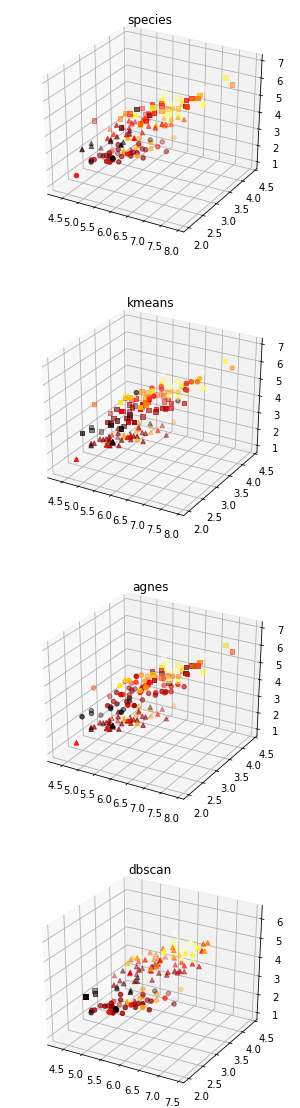

In [16]:
fig, ax = plt.subplots(4, figsize=(5,20), subplot_kw={'projection':'3d'})
for i, column in enumerate(['species', 'kmeans', 'agnes', 'dbscan']):
    ax[i].set_title(column)
    plot_iris_group(iris, column, ax[i])
plt.show()

---

# BUPA dataset using kmeans, agglomerative clustering (agnes), and DBSCAN

In [17]:
bupa = pd.read_csv('bupa.data', header=None, 
                  names = ['mcv', # mean corpuscular volume
                                  # normal range: 80-96 fL/red cell
                           'alkphos', # alkaline phosphotase
                           'sgpt', # alamine aminotransferase
                           'sgot', # aspartate aminotransferase
                           'gammagt', # gamma-glutamyl transpeptidase
                           'drinks', # number of half-pint equivalents of alcoholic beverages drunk per day
                           'selector', # field used to split data into two sets
                          ])
bupa = bupa.drop('selector', axis=1) # their split isn't relevant for us
bupa.drinks *= 1.5 # half pint = 8oz. standard "drink" is 12oz

In [18]:
bupa_attributes = ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt']

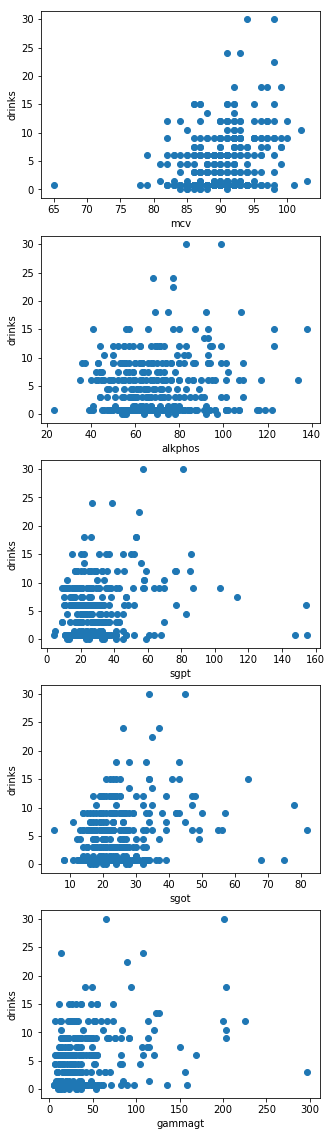

In [19]:
fig, axes = plt.subplots(len(bupa_attributes), figsize=(5,20))
for attr, ax in zip(bupa_attributes, axes):
    ax.set_xlabel(attr)
    ax.set_ylabel('drinks')
    ax.scatter(bupa[attr], bupa['drinks'])

In [20]:
bupa_kmeans = cluster.KMeans(2)

In [21]:
bupa['kmeans'] = bupa_kmeans.fit_predict(bupa[bupa_attributes])

In [22]:
bupa_agnes = cluster.AgglomerativeClustering(2)

In [23]:
bupa['agnes'] = bupa_agnes.fit_predict(bupa[bupa_attributes])

In [24]:
# not a good idea to use dbscan on this dataset

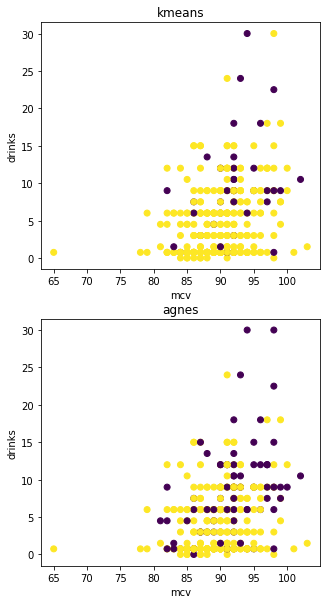

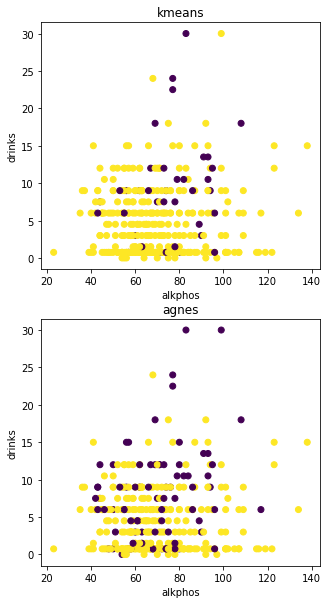

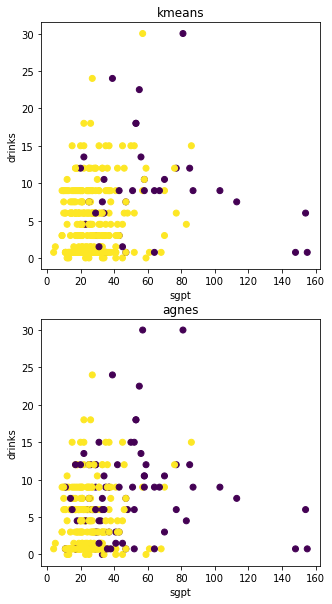

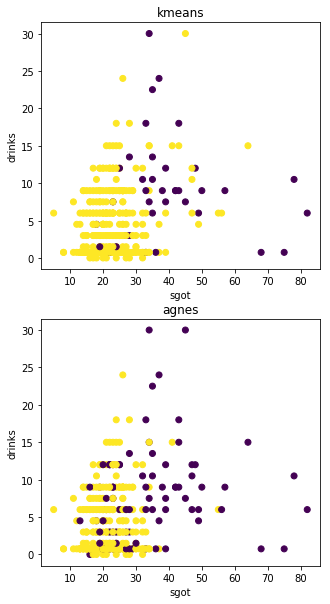

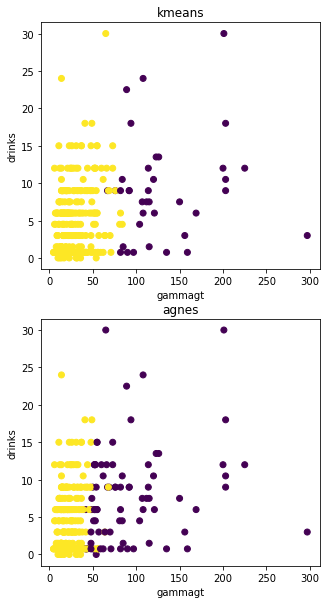

In [25]:
colors = ['r', 'b']
for attr in bupa_attributes:
    fig, axes = plt.subplots(2, figsize=(5,10))
    for model, ax in zip(['kmeans', 'agnes'], axes):
        ax.set_title(model)
        ax.set_xlabel(attr)
        ax.set_ylabel('drinks')
        ax.scatter(bupa[attr], bupa['drinks'], c=bupa[model], cmap='viridis')
    plt.show()

### Not so great

---

### Let's try generated data

In [26]:
from sklearn import datasets

In [70]:
circles, _ = datasets.make_moons(2000, True, 0.001, 43)

In [71]:
circles += 1,1
circles *= 3

In [72]:
blobs, _ = datasets.make_blobs(n_samples=2000, random_state=9)

In [73]:
blobs -= 1, 1

In [74]:
merged = np.concatenate((circles, blobs))

In [75]:
y = [i[1] for i in merged]
x = [i[0] for i in merged]

In [76]:
df = pd.DataFrame({'x': x, 'y' : y})

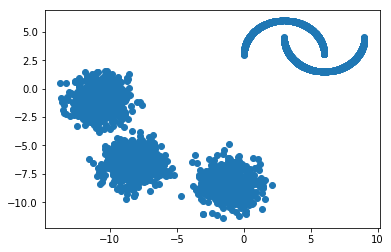

In [77]:
plt.scatter(df.x, df.y)

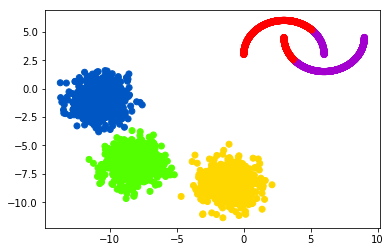

In [78]:
k = cluster.KMeans(5)
k.fit(df)
plt.scatter(df.x, df.y, c=k.labels_, cmap='prism')

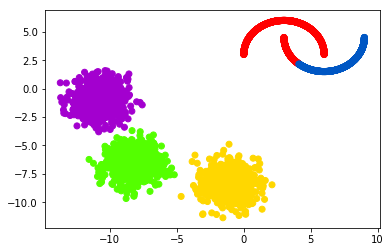

In [79]:
a = cluster.AgglomerativeClustering(5)
a.fit(df)
plt.scatter(df.x, df.y, c=a.labels_ ,cmap='prism')

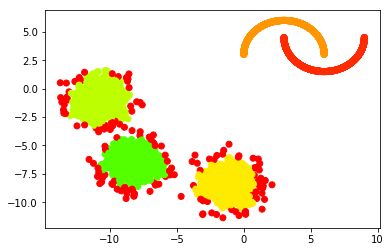

In [80]:
d = cluster.DBSCAN(.4, 7)
d.fit(df)
plt.scatter(df.x, df.y, c=d.labels_, cmap='prism', label='DBSCAN')

In [38]:
import kmeans

In [56]:
k = kmeans.KMeans(3, 1, 11)

In [57]:
k.fit(blobs)

In [58]:
classes = [k.predict(x) for x in blobs]

In [59]:
clusters = np.ndarray(shape=(3,2), dtype=np.float)
k.GetClusters(clusters)

In [60]:
y = [i[1] for i in blobs]
x = [i[0] for i in blobs]

centerx = [i[0] for i in clusters]
centery = [i[1] for i in clusters]

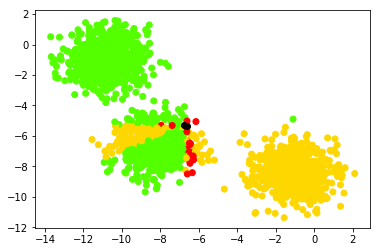

In [61]:
plt.scatter(x, y, c=classes, cmap='prism')
plt.scatter(centerx, centery, c='k')